In [32]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [33]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [34]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [35]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [36]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [37]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [38]:
# Save references to each table
# these two lines are mapping the measurements class and the stations class -RSW
#   - is that "saving references to each table"? -RSW
measurements = Base.classes.measurement
stations = Base.classes.station

# Find the column headers in each table
# This line creates an "inspector object" for the target, engine -RSW
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
print('measurements table column headings:')
for c in columns:
    print(c['name'], c["type"])
print('\nstations table column headings:')
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

measurements table column headings:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

stations table column headings:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [39]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [40]:
# Find the most recent date in the data set.

# session.query() returns a Query object
# .all() returns a list of everything returned in the Query object
sortedByDate = session.query(measurements).order_by(measurements.date).all()
print('Most Recent Measurement: ' + sortedByDate[-1].date)

Most Recent Measurement: 2017-08-23


In [41]:
#### get the info out of each measurement object and then put everything into a DataFrame ####
id_list = []
station_list = []
date_list = []
prcp_list = []
tobs_list = []
for measurement in sortedByDate:
    id_list.append(measurement.id)
    station_list.append(measurement.station)
    date_list.append(measurement.date)
    prcp_list.append(measurement.prcp)
    tobs_list.append(measurement.tobs)

measurementsDict = {
    'ID': id_list,
    'Station': station_list,
    'Date': date_list,
    'PRCP': prcp_list,
    'TOBS': tobs_list
}
measurementsDF = pd.DataFrame(measurementsDict)

#### pare it down to the last six months ####

# six months multiplied by the approx average number of days in a month
sixMonthsInDays = int(6*30.5)
# use np.datetime64 and np.timedelta64 to get the date six months before the last measurement
firstDate = np.datetime64(measurementsDF.iloc[-1,:]['Date']) - np.timedelta64(sixMonthsInDays, 'D')
# now use .loc to remove measurements taken before firstDate
measurementsDF = measurementsDF.loc[measurementsDF['Date']>=str(firstDate),:]
measurementsDF = measurementsDF[['Date','PRCP']]
measurementsDF = measurementsDF.set_index('Date')
measurementsDF = measurementsDF.sort_index() # I believe it was already sorted by date...
measurementsDF.head()

,PRCP
Date,
2017-02-21,0.06
2017-02-21,0.00
2017-02-21,0.00
2017-02-21,NaN
2017-02-21,0.00


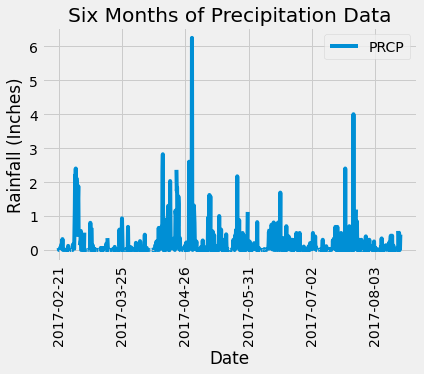

In [42]:
# plot the results using DataFrame.plot()
chart = measurementsDF.plot(rot = 90, title = 'Six Months of Precipitation Data', ylabel = 'Rainfall (Inches)')

In [43]:
# Use Pandas to print the summary statistics for the precipitation data
measurementsDF.describe()

,PRCP
count,981.000000
mean,0.164363
std,0.421057
min,0.000000
25%,0.000000
50%,0.010000
75%,0.120000
max,6.250000


# Exploratory Station Analysis

In [72]:
# Design a query to calculate the total number stations in the dataset
distinctStations = session.query(stations).distinct().all()
numStations = len(distinctStations)
print("There are " + str(numStations) + " stations in the data set.")
print('their names are: ')
for station in distinctStations:
    print(station.station)

There are 9 stations in the data set.
their names are: 
USC00519397
USC00513117
USC00514830
USC00517948
USC00518838
USC00519523
USC00519281
USC00511918
USC00516128


In [91]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
aCount = func.count('*').label('count')
stationsByActivity = session.query(aCount, measurements.station).\
    group_by(measurements.station).order_by(aCount.desc())
print('Stations by number of records\n\nStation        Records')
for station in stationsByActivity:
    print(station.station, '  ', station.count)
    
mostActiveStationRecord = stationsByActivity.all()[0]
print(f'\n\nThe most active station is {mostActiveStationRecord[1]}, '+
      f'with {mostActiveStationRecord[0]} recorded observations.')

Stations by number of records

Station        Records
USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838    511


The most active station is USC00519281, with 2772 recorded observations.


In [105]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
selector = [func.min(measurements.tobs), func.max(measurements.tobs), func.avg(measurements.tobs)]
activeStationTempStats = session.query(*selector).filter(measurements.station == mostActiveStationRecord[1]).all()
print(f'Temperature statistics for station {mostActiveStationRecord[1]}:')
print(f'Minimum observed temperature: {activeStationTempStats[0][0]}')
print(f'Maximum observed temperature: {activeStationTempStats[0][1]}')
print(f'Average observed temperature: ' + '{:.1f}'.format(activeStationTempStats[0][2]))

Temperature statistics for station USC00519281:
Minimum observed temperature: 54.0
Maximum observed temperature: 85.0
Average observed temperature: 71.7


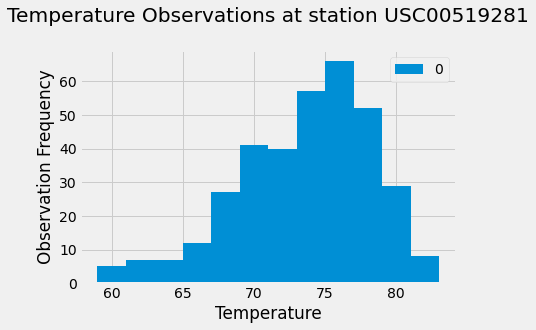

In [143]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
queryDate = dt.date.fromisoformat(sortedByDate[-1].date) - dt.timedelta(days = 365)
activeStationTempData = session.query(measurements.tobs).\
    filter(measurements.station == mostActiveStationRecord[1]).\
    filter(measurements.date > queryDate)
activeStationTempDF = pd.DataFrame(activeStationTempData)

activeStationTempDF.plot.hist(bins=12)
plt.legend(loc='best')
plt.xlabel('Temperature')
plt.ylabel('Observation Frequency')
plt.title(f'Temperature Observations at station {mostActiveStationRecord[1]}\n')
plt.show()

# Close session

In [144]:
# Close Session
session.close()